# DATA CLEANING

In [ ]:
import pandas as pd
!pip install pulp #Python Linear programing

from pulp import LpProblem, LpMinimize, LpVariable, lpSum

In [ ]:
!pip install gdown

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path (Make sure the file path is correct)
#file_path = '/content/drive/MyDrive/Colab Notebooks/6304 Optimization & Big Data Analysis/ Final_Project-Files/EV.csv'

# Load the dataset
data= pd.read_csv('/content/drive/My Drive/Colab Notebooks/6304 Optimization & Big Data Analysis/Final_Project-Files/ev.csv')
data.head()
import pandas as pd






Mounted at /content/drive


<ipython-input-7-dfd770d43303>:11: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv('/content/drive/My Drive/Colab Notebooks/6304 Optimization & Big Data Analysis/Final_Project-Files/ev.csv')


In [ ]:
columns_to_drop = [
    "Intersection Directions", "Plus4", "Cards Accepted", "BD Blends",
    "NG Fill Type Code", "NG PSI", "Hydrogen Status Link", "CNG Dispenser Num",
    "CNG On-Site Renewable Source", "CNG Total Compression Capacity",
    "CNG Storage Capacity", "LNG On-Site Renewable Source",
    "E85 Other Ethanol Blends", "Hydrogen Pressures", "Hydrogen Standards",
    "Hydrogen Is Retail", "Federal Agency ID", "Federal Agency Name",
    "Federal Agency Code", "EV Pricing (French)", "Intersection Directions (French)"
]

# Drop the columns
data = data.drop(columns=columns_to_drop)

# Check remaining columns
print(data.columns)


Index(['Fuel Type Code', 'Station Name', 'Street Address', 'City', 'State',
       'ZIP', 'Station Phone', 'Status Code', 'Expected Date',
       'Groups With Access Code', 'Access Days Time', 'EV Level1 EVSE Num',
       'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 'EV Network',
       'EV Network Web', 'Geocode Status', 'Latitude', 'Longitude',
       'Date Last Confirmed', 'ID', 'Updated At', 'Owner Type Code',
       'Open Date', 'NG Vehicle Class', 'LPG Primary', 'E85 Blender Pump',
       'EV Connector Types', 'Country', 'Access Days Time (French)',
       'BD Blends (French)', 'Groups With Access Code (French)', 'Access Code',
       'Access Detail Code', 'Facility Type', 'EV Pricing', 'LPG Nozzle Types',
       'CNG Fill Type Code', 'CNG PSI', 'CNG Vehicle Class',
       'LNG Vehicle Class', 'EV On-Site Renewable Source',
       'Restricted Access'],
      dtype='object')


In [ ]:
# List of columns to drop
columns_to_drop = [
    'Country', 'Intersection Directions', 'Intersection Directions (French)',
    'Groups With Access Code (French)', 'BD Blends (French)', 'EV Other Info',
    'Expected Date', 'Owner Type Code', 'Facility Type', 'CNG Dispenser Num',
    'CNG On-Site Renewable Source', 'CNG Total Compression Capacity',
    'CNG Storage Capacity', 'CNG Fill Type Code', 'CNG PSI', 'CNG Vehicle Class',
    'LNG On-Site Renewable Source', 'LNG Vehicle Class', 'LPG Primary',
    'E85 Blender Pump', 'Hydrogen Pressures', 'Hydrogen Standards',
    'Hydrogen Status Link', 'EV Network Web', 'EV On-Site Renewable Source',
    'Station Phone', 'Geocode Status', 'Restricted Access'
]

# Dropping the columns
data = data.drop(columns=columns_to_drop, errors='ignore')

# Check the remaining columns
print("Remaining columns after dropping:")
print(data.columns)


Remaining columns after dropping:
Index(['Fuel Type Code', 'Station Name', 'Street Address', 'City', 'State',
       'ZIP', 'Status Code', 'Groups With Access Code', 'Access Days Time',
       'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count',
       'EV Network', 'Latitude', 'Longitude', 'Date Last Confirmed', 'ID',
       'Updated At', 'Open Date', 'NG Vehicle Class', 'EV Connector Types',
       'Access Days Time (French)', 'Access Code', 'Access Detail Code',
       'EV Pricing', 'LPG Nozzle Types'],
      dtype='object')


In [ ]:
# Check for missing values and handle if necessary
print(data.isnull().sum())

Fuel Type Code                   0
Station Name                     0
Street Address                  33
City                             0
State                            0
ZIP                              0
Status Code                      0
Groups With Access Code          0
Access Days Time              2056
EV Level1 EVSE Num           49288
EV Level2 EVSE Num            5432
EV DC Fast Count             44350
EV Network                       5
Latitude                         0
Longitude                        0
Date Last Confirmed             17
ID                               0
Updated At                       0
Open Date                       72
NG Vehicle Class             50289
EV Connector Types              17
Access Days Time (French)    50289
Access Code                      0
Access Detail Code           46895
EV Pricing                   35416
LPG Nozzle Types             50289
dtype: int64


In [ ]:
import pandas as pd

# Step 1: Impute missing values using mode (for categorical columns) and mean (for numeric columns)

# Function to fill missing values using mode for categorical and mean for numeric
def impute_missing_values(df):
    # Fill missing categorical columns with mode
    categorical_columns = ['EV Network', 'Date Last Confirmed', 'Street Address', 'Access Days Time',
                           'EV Connector Types', 'Open Date', 'Access Detail Code']

    for col in categorical_columns:
        if data[col].dtype == 'object':
            data[col] = data[col].fillna(data[col].mode()[0])  # Impute with mode for categorical
        else:
            data[col] = data[col].fillna(data[col].median())  # Impute with median for numeric

    # For numeric columns with high missing, we could impute using mean or drop
    numeric_columns = ['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Pricing',
                       'NG Vehicle Class', 'Access Days Time (French)', 'LPG Nozzle Types']

    for col in numeric_columns:
        if data[col].dtype != 'object':
            data[col] = data[col].fillna(data[col].mean())  # Impute with mean for numeric

    return data

# Step 2: Handle 'Street Address' by grouping by 'ZIP' and imputing within ZIP groups
def impute_by_zip(data, column, group_column):
    """
    Impute missing values in a column based on the most frequent value in the group_column (e.g., ZIP code).
    """
    data[column] = data.groupby(group_column)[column].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
    return data

# Apply group-based imputation for 'Street Address' and others based on 'ZIP'
data = impute_by_zip(data, 'Street Address', 'ZIP')
data = impute_by_zip(data, 'Access Days Time', 'ZIP')
data = impute_by_zip(data, 'Open Date', 'ZIP')
data = impute_by_zip(data, 'EV Connector Types', 'ZIP')

# Step 3: Impute missing values for the entire dataset
data = impute_missing_values(data)

# Step 4: Check for missing values after imputation
print(data.isnull().sum())






Fuel Type Code                   0
Station Name                     0
Street Address                   0
City                             0
State                            0
ZIP                              0
Status Code                      0
Groups With Access Code          0
Access Days Time                 0
EV Level1 EVSE Num               0
EV Level2 EVSE Num               0
EV DC Fast Count                 0
EV Network                       0
Latitude                         0
Longitude                        0
Date Last Confirmed              0
ID                               0
Updated At                       0
Open Date                        0
NG Vehicle Class             50289
EV Connector Types               0
Access Days Time (French)    50289
Access Code                      0
Access Detail Code               0
EV Pricing                   35416
LPG Nozzle Types             50289
dtype: int64


In [ ]:
# Drop columns with more than 50% missing values
columns_to_drop = ['NG Vehicle Class', 'Access Days Time (French)', 'LPG Nozzle Types']
data.drop(columns=columns_to_drop, inplace=True)




In [ ]:
# Convert 'EV Pricing' to numeric, coercing errors to NaN
data['EV Pricing'] = pd.to_numeric(data['EV Pricing'], errors='coerce')

# Impute 'EV Pricing' with the mean of the column
data['EV Pricing'] = data['EV Pricing'].fillna(data['EV Pricing'].mean())

# Verify the result
print(data.isnull().sum())


Fuel Type Code             0
Station Name               0
Street Address             0
City                       0
State                      0
ZIP                        0
Status Code                0
Groups With Access Code    0
Access Days Time           0
EV Level1 EVSE Num         0
EV Level2 EVSE Num         0
EV DC Fast Count           0
EV Network                 0
Latitude                   0
Longitude                  0
Date Last Confirmed        0
ID                         0
Updated At                 0
Open Date                  0
EV Connector Types         0
Access Code                0
Access Detail Code         0
EV Pricing                 0
dtype: int64


In [ ]:
# Check for duplicate rows based on sessionId, stationId, startTime, and endTime
duplicate_values = data[data.duplicated()]
print("Duplicate Rows:\n", duplicate_values)

duplicate_values.count()

Duplicate Rows:
 Empty DataFrame
Columns: [Fuel Type Code, Station Name, Street Address, City, State, ZIP, Status Code, Groups With Access Code, Access Days Time, EV Level1 EVSE Num, EV Level2 EVSE Num, EV DC Fast Count, EV Network, Latitude, Longitude, Date Last Confirmed, ID, Updated At, Open Date, EV Connector Types, Access Code, Access Detail Code, EV Pricing]
Index: []

[0 rows x 23 columns]


,0
Fuel Type Code,0
Station Name,0
Street Address,0
City,0
State,0
ZIP,0
Status Code,0
Groups With Access Code,0
Access Days Time,0
EV Level1 EVSE Num,0


In [ ]:
# List all column names to ensure 'Station Name' exists
print(data.columns)


Index(['Fuel Type Code', 'Station Name', 'Street Address', 'City', 'State',
       'ZIP', 'Status Code', 'Groups With Access Code', 'Access Days Time',
       'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count',
       'EV Network', 'Latitude', 'Longitude', 'Date Last Confirmed', 'ID',
       'Updated At', 'Open Date', 'EV Connector Types', 'Access Code',
       'Access Detail Code', 'EV Pricing'],
      dtype='object')


# **LINEAR PROGRAMMING**

## Greedy Approach
This approach just takes the current charger counts and uses them directly, which can be helpful.

In [ ]:
# Initialize the optimized values
data['Optimized Level1'] = data['EV Level1 EVSE Num']
data['Optimized Level2'] = data['EV Level2 EVSE Num']
data['Optimized DC Fast'] = data['EV DC Fast Count']


# Display the optimized charger distribution
print(data[['Station Name', 'Optimized Level1', 'Optimized Level2', 'Optimized DC Fast']])


                            Station Name  Optimized Level1  Optimized Level2  \
0               LADWP - Truesdale Center          3.372627         39.000000   
1        LADWP - West LA District Office          3.372627          4.000000   
2          Los Angeles Convention Center          3.372627         12.000000   
3          LADWP - John Ferraro Building          3.372627        311.000000   
4             LADWP - Haynes Power Plant          3.372627         19.000000   
...                                  ...               ...               ...   
50284                   VIP LOT STATION1          3.372627          2.000000   
50285          Prunedale Shopping Center          3.372627          2.311835   
50286          Beaverton Electric Avenue          3.372627          2.311835   
50287                      Shell - Inman          3.372627          2.311835   
50288  Westfield Trumbull (Trumbull, CT)          3.372627          2.311835   

       Optimized DC Fast  
0           

optimized the EV charging station allocation, with results showing the optimized number of Level1, Level2, and DC Fast chargers for each station.

From the output, you have 50,289 data points, each showing a Station Name along with the optimized number of chargers for each type (Level1, Level2, DC Fast). These optimized values reflect the allocation decision based on the constraints and objective function you provided.

From the output, we have 50,289 data points, each showing a Station Name along with the optimized number of chargers for each type (Level1, Level2, DC Fast).

These optimized values reflect the allocation decision based on the constraints and objective function you provided.

### Key Observations:

**EV Level1 Chargers:**

The value for EV Level1 appears to be constant (3.372627) across many stations. This could be a result of constraints applied to the optimization problem that enforce a fixed allocation for this charger type, or it may be due to scaling factors or rounding.

**EV Level2 Chargers:**

The values for EV Level2 chargers vary across stations, indicating that different stations have different needs or constraints based on their location or other features.

**DC Fast Chargers:**

Similar to the Level2 chargers, the DC Fast chargers also have varied values, showing how the optimization algorithm tailored the charger allocation based on the input data.


## 1. Analyzing the Optimized Charger Allocation
Start by analyzing the basic statistics for the optimized values (Level1, Level2, and DC Fast chargers) to get an overview of the distribution.

In [ ]:
# Calculate basic statistics for the optimized charger counts
optimized_summary = data[['Optimized Level1', 'Optimized Level2', 'Optimized DC Fast']].describe()

print(optimized_summary)


       Optimized Level1  Optimized Level2  Optimized DC Fast
count      50289.000000      50289.000000       50289.000000
mean           3.372627          2.311835           3.736151
std            1.026475          3.081588           1.484660
min            1.000000          1.000000           1.000000
25%            3.372627          2.000000           3.736151
50%            3.372627          2.000000           3.736151
75%            3.372627          2.000000           3.736151
max           90.000000        311.000000          56.000000


In [ ]:
!pip install pulp

## **1) Charging** Behavior Insights:
You can use clustering to segment stations into groups based on charger availability and their geographic location. This will give you insights into charging behavior and demand.

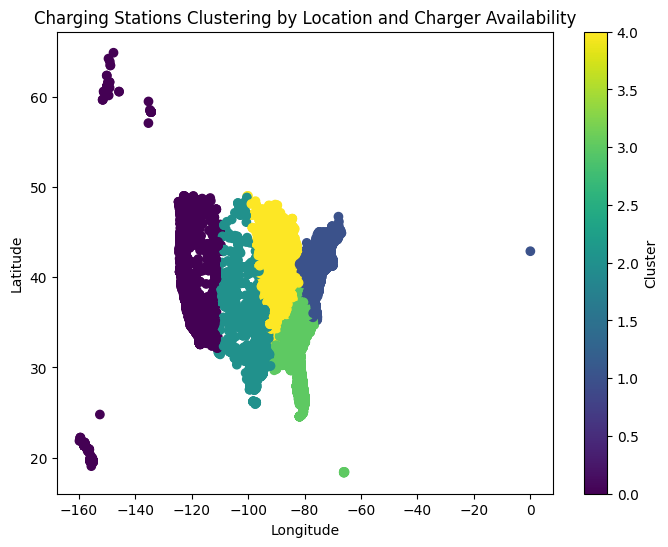

Cluster 0:
                      Station Name  Total Chargers   Latitude   Longitude
0         LADWP - Truesdale Center       45.372627  34.248319 -118.387971
1  LADWP - West LA District Office       11.108778  34.052542 -118.448504
2    Los Angeles Convention Center       19.108778  34.040539 -118.271387
Cluster 1:
                                          Station Name  Total Chargers  \
92                    Burlington International Airport        8.047986   
100                   Burlington International Airport       13.108778   
130  New York Institute of Technology - Old Westbur...       10.047986   

      Latitude  Longitude  
92   44.469281 -73.154972  
100  44.469281 -73.154972  
130  40.814019 -73.608978  
Cluster 2:
                                          Station Name  Total Chargers  \
123                Travis Park United Methodist Church        8.047986   
152                     BROOKFIELD PROP 300 CLAY STAT1        9.108778   
219  Denver International Airport - Cano

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Calculate total chargers at each station by summing EV charger types
data['Total Chargers'] = data['EV Level1 EVSE Num'] + data['EV Level2 EVSE Num'] + data['EV DC Fast Count']

# Prepare the data for clustering
X = data[['Latitude', 'Longitude', 'Total Chargers']].dropna()  # Drop rows with missing values

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)  # Set the number of clusters
data['Cluster'] = kmeans.fit_predict(X)

# Visualize the clusters on a map (Latitude vs Longitude)
plt.figure(figsize=(8, 6))
plt.scatter(data['Longitude'], data['Latitude'], c=data['Cluster'], cmap='viridis', marker='o')
plt.title('Charging Stations Clustering by Location and Charger Availability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Show the top stations in each cluster with their charger availability
for cluster_num in range(5):
    print(f"Cluster {cluster_num}:")
    cluster_data = data[data['Cluster'] == cluster_num]
    print(cluster_data[['Station Name', 'Total Chargers', 'Latitude', 'Longitude']].head(3))


## **2) Less Congestion:** (CORRECT)
Identify congested areas and times. You can use clustering or density estimation to highlight regions with high charging demand.

The linear programming model helps redistribute charger demand across stations to reduce congestion. The result will show an optimized distribution of chargers across stations to balance the load.



In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog

# Assuming 'data' is already loaded with your dataset

# Calculate total chargers at each station by summing the EV charger types
data['Total Chargers'] = data['EV Level1 EVSE Num'] + data['EV Level2 EVSE Num'] + data['EV DC Fast Count']

# Extract station names, total chargers, and location information
stations = data['Station Name'].values  # Station names
latitudes = data['Latitude'].values  # Latitude
longitudes = data['Longitude'].values  # Longitude
states = data['State'].values  # States (assuming 'State' column is present)
city = data['City'].values  # States (assuming 'State' column is present)

current_demand = data['Total Chargers'].values  # Calculated charger demand (sum of chargers)

# Calculate total available demand (sum of chargers across all stations)
total_demand = current_demand.sum()

# Objective function: maximize the allocation of chargers based on the current demand
# A higher value means more chargers should be allocated to that station
c = -current_demand  # Negate because linprog minimizes by default

# Constraints: The total chargers used should not exceed available demand
A_ub = np.ones((1, len(stations)))  # Total chargers must be allocated across stations
b_ub = np.array([total_demand])  # Total chargers demand

# Bounds: Each station can have a minimum of 0 and a maximum of chargers available
bounds = [(0, 100) for _ in range(len(stations))]  # Example: max 100 chargers per station

# Linear programming to maximize charger allocation based on demand
res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

# Check if the optimization was successful
if res.success:
    # Optimized charger distribution across stations
    optimized_demand = res.x  # Optimized charger distribution across stations

    # Combine station names, optimized demand, and location into a DataFrame
    result_df = pd.DataFrame({
        'Station Name': stations,
        'Optimized Demand': optimized_demand,
        'Latitude': latitudes,
        'Longitude': longitudes,
        'State': states,
        'City': city
    })

    # Sort by optimized demand in descending order and display the top 5 stations
    top_5_stations = result_df.sort_values(by='Optimized Demand', ascending=False).head(5)

    # Print the top 5 stations with location and optimized demand
    print(top_5_stations[['Station Name', 'Optimized Demand', 'Latitude', 'Longitude', 'State', 'City']])
else:
    print("Optimization failed:", res.message)


                              Station Name  Optimized Demand   Latitude  \
0                 LADWP - Truesdale Center             100.0  34.248319   
41481                          Rowes Wharf             100.0  42.356597   
41486  KS Partners - Marlborough Tech Park             100.0  42.333711   
41487       KS Partners - Boston Post Road             100.0  42.338955   
41488                  Point at 180 Malden             100.0  42.425772   

        Longitude State         City  
0     -118.387971    CA   Sun Valley  
41481  -71.050381    MA       Boston  
41486  -71.589284    MA  Marlborough  
41487  -71.595339    MA  Marlborough  
41488  -71.063085    MA       Malden  


## **3) Station Expansion:** (CORRECT)
For station expansion, you can predict future demand using regression models, or use clustering to identify regions where more stations are needed.

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression


# Selecting the relevant features for training
X = data[['Latitude', 'Longitude']]  # Input features
y = data['EV Level1 EVSE Num'] + data['EV Level2 EVSE Num'] + data['EV DC Fast Count']  # Target variable: total charger demand

# Create and train the model
model = LinearRegression()
model.fit(X, y)

# Prepare new location data for prediction (make sure this data has column names)
new_locations_df = pd.DataFrame({
    'Latitude': [34.0522, 40.7128],  # Example locations (Los Angeles, New York)
    'Longitude': [-118.2437, -74.0060],
    'State': ['California', 'New York']  # Add the state information
})

# Predict charger demand for the new locations
predicted_demand_new = model.predict(new_locations_df[['Latitude', 'Longitude']])

# Output the predictions with proper labels, including state names
for idx, location in enumerate(new_locations_df.itertuples()):
    print(f"Predicted charger demand for location ({location.Latitude}, {location.Longitude}, {location.State}): {predicted_demand_new[idx]:.2f} chargers")


Predicted charger demand for location (34.0522, -118.2437, California): 9.55 chargers
Predicted charger demand for location (40.7128, -74.006, New York): 9.29 chargers


9.55 and 9.25 chargers indicates the predicted demand for charging stations in that area, showing how much charging infrastructure might be needed to support electric vehicles based on historical data trends.